# Time Series with Fitbit Data

## Goals
###    - Interpret and analyze the data on the thumb drive
###    - Organize the data into a tidy dataset
###    - Predict the next two weeks worth of data using time series modeling

## Summary
#### - We have fitbit data for a user covering April - December 2018
#### - User Traits: 
    - Nationality: American (U.S)
    - Gender: Male
    - Age: 24 - 30
    - Height: 5'7 - 5'11
    - Weight: 145 - 200 lbs
#### - Which model did we use?

## Set up Environment

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# datetime manipulations
from datetime import datetime
import itertools as it

# modeling
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# supporting modules
import summarize
import acquire
import prepare

## Acquire

The data on the thumb drive contains 8 separate csv files listing daily activities and caloric intake. Each file contains a different time frame. The total time frame covers April 26th, 2018 through December 6th, 2018.

Drop caloric intake data due to excessive nulls. (96% null)
Combine data into one csv using copy/paste 

In [2]:
df = acquire.acquire_data()

In [3]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


*Summary of the data we pulled in.*

In [4]:
summarize.df_summary(df)

--- Shape: (225, 10)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null object
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB
--- Descriptions
           date calories_burned steps    distance      floors  \
count       225             225   225  225.000000  225.000000   
unique      225             207   213         NaN         NaN   
top     10/3/18           2,145     0         NaN         NaN   
freq          1               4    12         NaN         NaN   
mea

## Prepare

In [5]:
df = prepare.prepare_data(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 11 columns):
calories_burned           225 non-null int64
steps                     225 non-null int64
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null int64
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null int64
total_minutes_logged      225 non-null int64
distance_per_step         213 non-null float64
dtypes: float64(2), int64(9)
memory usage: 21.1 KB


In [7]:
df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471


**Takeaway:** Our fitbit wearer has an average stride of 2.4816, so chances are it is a male.

In [8]:
df = prepare.impute_zeros(df)

In [9]:
# dont know if miles or km
# mile = 2.5 step stride
# km = 1.5 step stride

# if we assume that steps are in miles, we can assume the participant is an American, therefore cn take American holidays into consideration
# taking calorie intake and stride into account, can find approximate weight for either male or female
# day of the week vs floor count - is there a spike difference?

In [10]:
# look at the steps average in days, weeks, and months

In [11]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
floors                      int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
total_minutes_logged        int64
distance_per_step         float64
dtype: object

In [12]:
no_steps = df[df.steps == 0]

In [13]:
no_steps['weekday_name'] = no_steps.index.weekday_name

In [14]:
no_steps.head(12)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday_name


In [15]:
#weekday_means = round(df.groupby(df.index.month).mean(),2)

In [16]:
weekday_means = df.resample('D').mean()

In [17]:
weekday_means.steps.value_counts(ascending=False).head()

6916    13
6480     2
9215     1
4313     1
7806     1
Name: steps, dtype: int64

In [18]:
weekday_means.steps.describe()

count      225.000000
mean      8905.040000
std       4870.654569
min         21.000000
25%       5666.000000
50%       7806.000000
75%      12380.000000
max      25512.000000
Name: steps, dtype: float64

In [19]:
df['distance'].replace(to_replace= 0, value= 1.88, inplace=True)

In [20]:
df['distance_per_step'] = df['distance_per_step'].replace(to_replace= 0, value= .0000471, inplace=True)

In [21]:
df['steps'] = df['steps'].replace(to_replace= 0, value= 30647)

In [22]:
df.sort_values(by='steps', ascending = False)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-11-18,4832,25512,12.00,23,450,269,53,154,3373,926,None
2018-11-04,4578,21302,10.05,11,561,256,62,99,2907,978,None
2018-10-07,4799,20396,9.62,30,402,329,76,100,3344,907,None
2018-11-17,4548,20395,10.06,31,464,347,54,90,3077,955,None
2018-10-28,4450,19956,9.41,9,632,239,52,112,2834,1035,None
2018-08-05,4818,18565,8.76,29,561,272,31,113,3106,977,None
2018-08-03,4762,18215,8.59,12,607,247,17,114,2958,985,None
2018-11-11,4264,17761,8.36,129,486,299,47,76,2717,908,None
2018-08-11,4392,17519,8.26,21,448,260,20,94,2616,822,None


In [23]:
df.shape

(225, 11)

## Exploration

*Look at each feature to search to trends, anomalies, and correlations.*

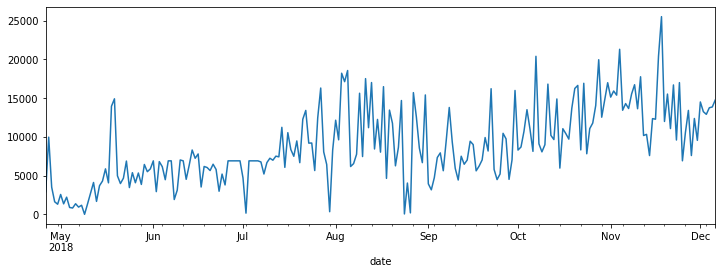

In [24]:
df['steps'].resample("D").mean().plot(figsize=(12,4))

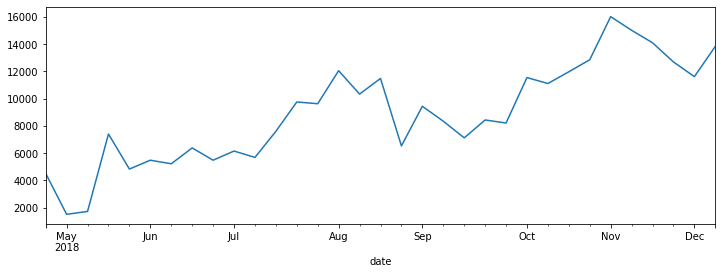

In [25]:
df['steps'].resample("W").mean().plot(figsize=(12,4))

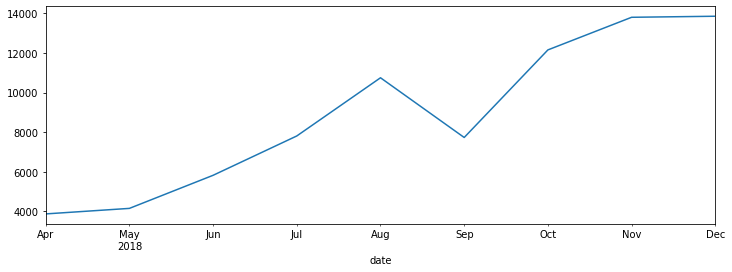

In [26]:
df['steps'].resample("M").mean().plot(figsize=(12,4))

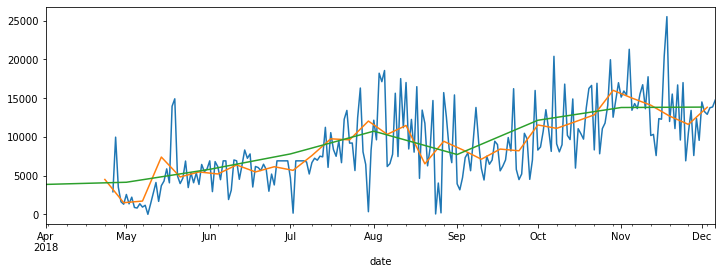

In [27]:
df['steps'].resample("D").mean().plot(figsize=(12,4))
df['steps'].resample("W").mean().plot(figsize=(12,4))
df['steps'].resample("M").mean().plot(figsize=(12,4))

In [28]:
# look for days when there is a zero value
df.steps.sort_values().head(15)

date
2018-05-09      21
2018-08-24      68
2018-07-02     172
2018-08-26     207
2018-07-30     357
2018-05-05     833
2018-05-04     904
2018-05-07     952
2018-05-08    1187
2018-04-30    1323
2018-05-10    1364
2018-05-02    1372
2018-05-06    1383
2018-04-29    1639
2018-05-13    1689
Name: steps, dtype: int64

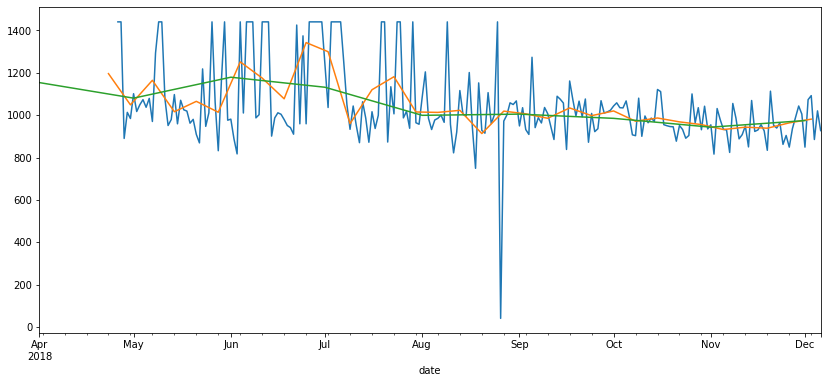

In [29]:
# started off strong in the beginning and then began to fall off the wagon a bit in the end
df['total_minutes_logged'].resample("D").mean().plot(figsize=(14,6))
df['total_minutes_logged'].resample("W").mean().plot(figsize=(14,6))
df['total_minutes_logged'].resample("M").mean().plot(figsize=(14,6))

In [30]:
df.total_minutes_logged.sort_values().head(15)

date
2018-08-26     41
2018-08-18    749
2018-11-02    816
2018-06-03    817
2018-08-11    822
2018-11-07    824
2018-05-28    832
2018-11-19    834
2018-09-16    838
2018-11-26    849
2018-12-01    849
2018-11-13    850
2018-11-24    862
2018-05-22    869
2018-07-12    870
Name: total_minutes_logged, dtype: int64

In [31]:
# which month(s) has lowest amount of logged activity
df1 = df.resample("M").mean()
df1.sort_values(by='total_minutes_logged', ascending=True)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged
date,,,,,,,,,,
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.700000,67.366667,2111.433333,943.166667
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.580645,55.612903,1779.903226,984.741935
2018-08-31,3753.612903,10743.967742,5.075161,12.645161,717.354839,216.419355,16.322581,55.225806,1901.935484,999.032258
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,15.533333,29.666667,1346.866667,1004.700000
2018-05-31,3116.032258,4156.032258,1.960000,4.096774,908.483871,151.709677,18.258065,19.580645,984.967742,1080.096774
2018-07-31,3317.290323,7809.129032,3.650968,6.903226,920.000000,182.677419,21.870968,28.161290,1417.774194,1131.548387
2018-04-30,3067.800000,3877.000000,1.826000,7.000000,995.600000,138.600000,23.800000,18.800000,916.800000,1153.400000
2018-06-30,2972.600000,5824.800000,2.678000,5.033333,1012.233333,192.300000,16.800000,14.000000,1234.400000,1178.866667


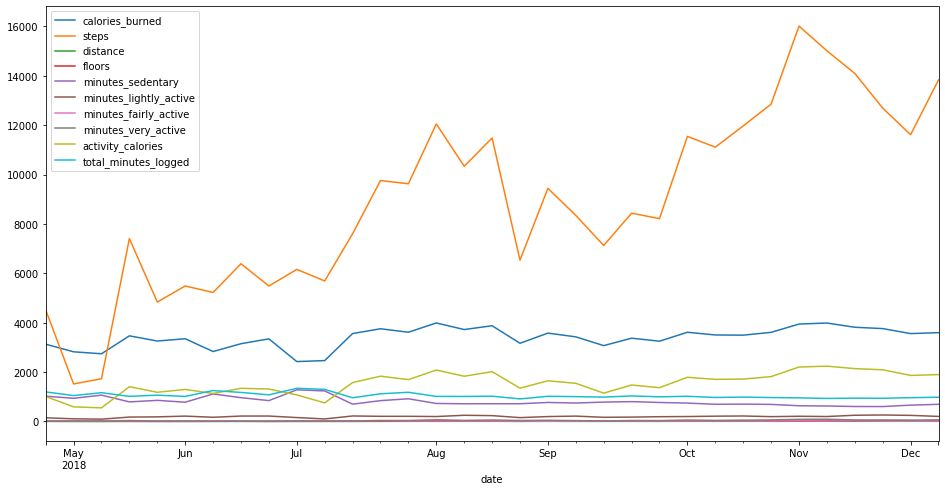

In [32]:
fig = df.resample("W").mean().plot(figsize=(16,8))

In [33]:
df.sort_index().steps.sort_values(ascending=True).head(15)

date
2018-05-09      21
2018-08-24      68
2018-07-02     172
2018-08-26     207
2018-07-30     357
2018-05-05     833
2018-05-04     904
2018-05-07     952
2018-05-08    1187
2018-04-30    1323
2018-05-10    1364
2018-05-02    1372
2018-05-06    1383
2018-04-29    1639
2018-05-13    1689
Name: steps, dtype: int64

### Calories Burned

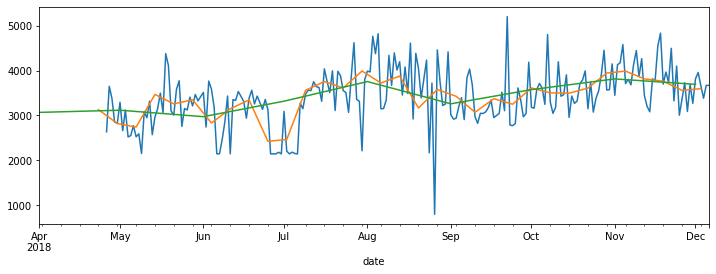

In [34]:
df['calories_burned'].resample("D").mean().plot(figsize=(12,4))
df['calories_burned'].resample("W").mean().plot(figsize=(12,4))
df['calories_burned'].resample("M").mean().plot(figsize=(12,4))

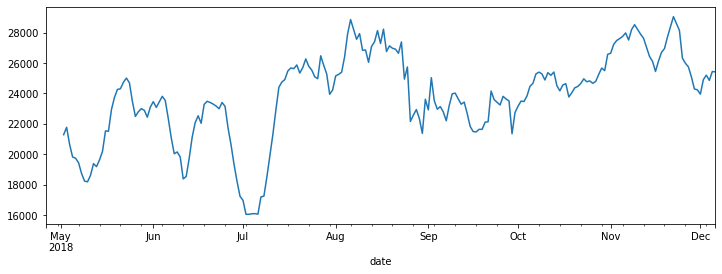

In [35]:
# every 7 days compared to resample("D")
df['calories_burned'].rolling(7).sum().plot(figsize=(12,4))

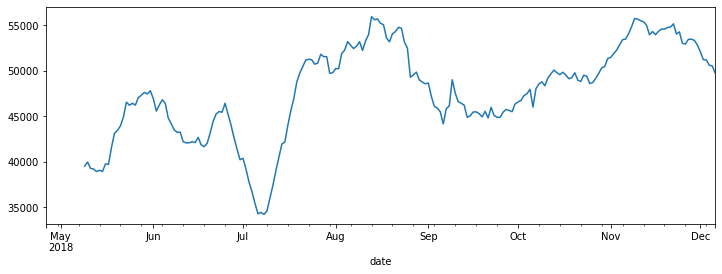

In [36]:
# every two weeks
df['calories_burned'].rolling(14).sum().plot(figsize=(12,4))

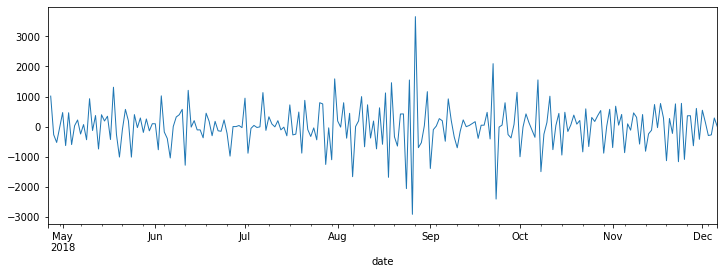

In [37]:
# difference between day to day
# something around the end of august
# task: look at month of august
df['calories_burned'].resample("D").mean().diff().plot(figsize=(12,4), linewidth=1)

*Add in a weekday and month column to look for seasonality in those time framses.*

In [38]:
df['weekday'] = df.index.weekday_name

In [39]:
df['month'] = df.index.month

In [40]:
df.head(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,weekday,month
date,,,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,17,22,566,1440,None,Thursday,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,None,Friday,4


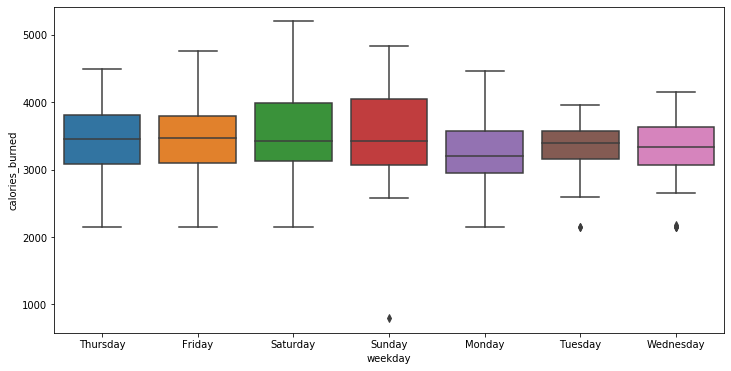

In [41]:
# burned more calories during the weekends
# a few outliers on Sundays/Tuesdays/Wednesdays
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='weekday', y='calories_burned')

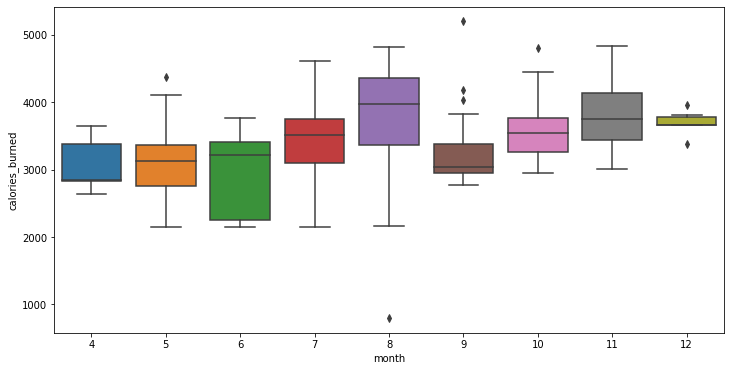

In [42]:
# more outliers each month for calories burned
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='month', y='calories_burned')

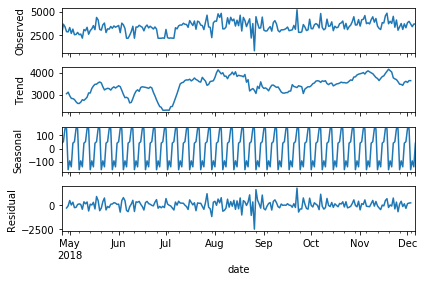

In [43]:
# no real trend in calories burned..
# no idea what seasonal is telling me
# residual looks very similar to observed 
# task: look at month
decomp = sm.tsa.seasonal_decompose(df['calories_burned'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

In [44]:
# look at the trend for monthly

# decomp = sm.tsa.seasonal_decompose(df['calories_burned'].resample("M").mean(), model='additive')
# fig = decomp.plot()
# plt.show()

### Steps

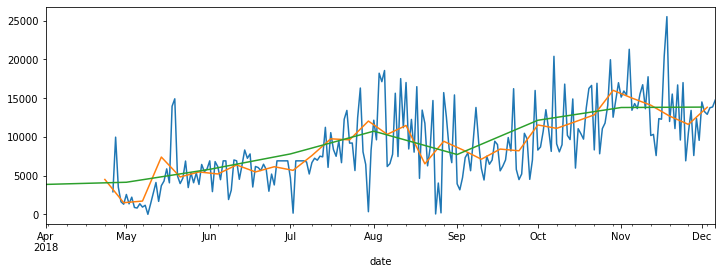

In [45]:
# steps
# uphill trend
# what do the peaks and valleys mean?
df['steps'].resample("D").mean().plot(figsize=(12,4))
df['steps'].resample("W").mean().plot(figsize=(12,4))
df['steps'].resample("M").mean().plot(figsize=(12,4))

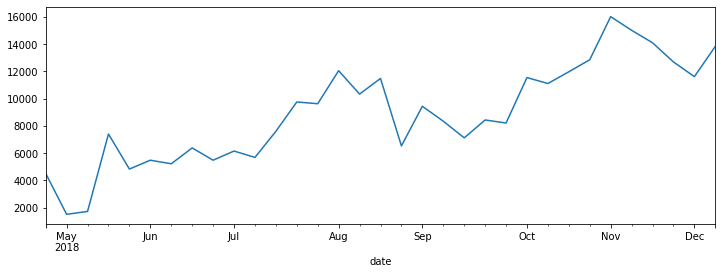

In [46]:
df['steps'].resample("W").mean().plot(figsize=(12,4))

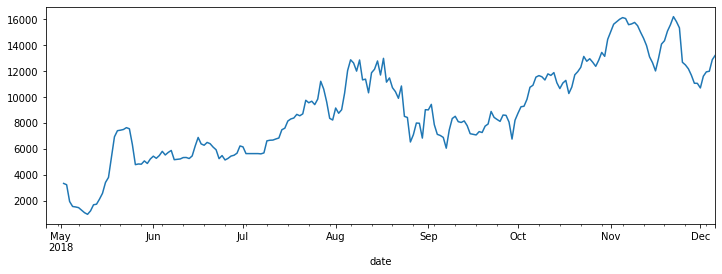

In [47]:
# how is this different from week? More rigidity in lines for this one
df['steps'].rolling(7).mean().plot(figsize=(12,4))

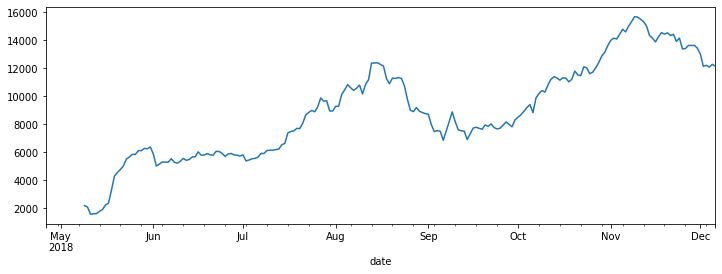

In [48]:
# every 2 weeks, see a clearer trend
df['steps'].rolling(14).mean().plot(figsize=(12,4))

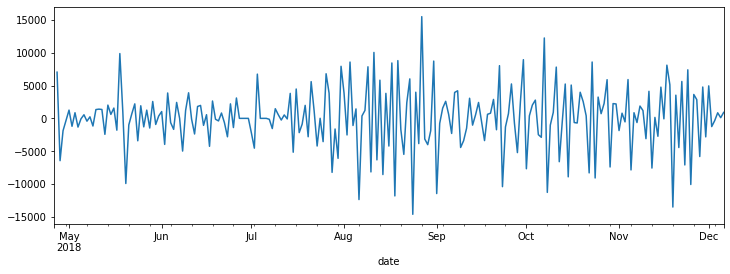

In [49]:
# there are differences from day to day that grow as the months go, there are more periods of negative the longer the wearer has the fitbit
df['steps'].resample("D").mean().diff().plot(figsize=(12,4))

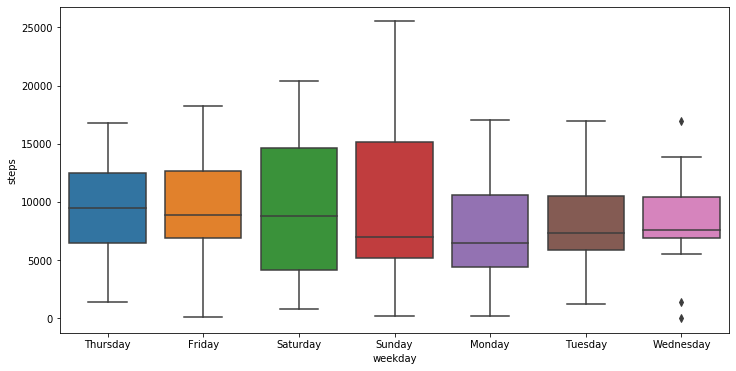

In [50]:
# again, can see that some days more active that others
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='weekday', y='steps')

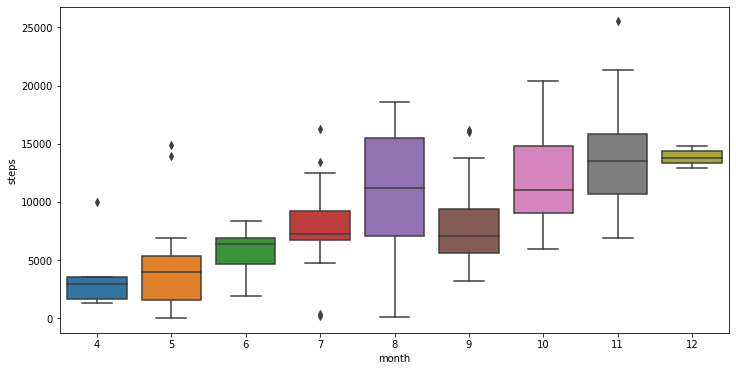

In [51]:
# outliers
# august 
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='month', y='steps')

In [52]:
# august is 4th highest in steps --> look at box plot
# deal with outliers? figure out what they are 
df1.sort_values(by='steps', ascending=False)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged
date,,,,,,,,,,
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.700000,67.366667,2111.433333,943.166667
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.580645,55.612903,1779.903226,984.741935
2018-08-31,3753.612903,10743.967742,5.075161,12.645161,717.354839,216.419355,16.322581,55.225806,1901.935484,999.032258
2018-07-31,3317.290323,7809.129032,3.650968,6.903226,920.000000,182.677419,21.870968,28.161290,1417.774194,1131.548387
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,15.533333,29.666667,1346.866667,1004.700000
2018-06-30,2972.600000,5824.800000,2.678000,5.033333,1012.233333,192.300000,16.800000,14.000000,1234.400000,1178.866667
2018-05-31,3116.032258,4156.032258,1.960000,4.096774,908.483871,151.709677,18.258065,19.580645,984.967742,1080.096774
2018-04-30,3067.800000,3877.000000,1.826000,7.000000,995.600000,138.600000,23.800000,18.800000,916.800000,1153.400000


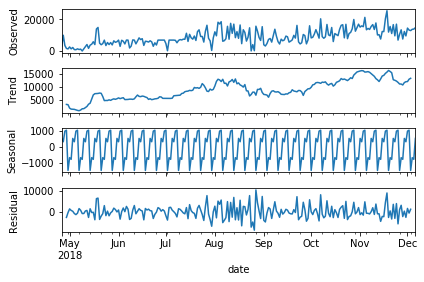

In [53]:
# uneven trend in steps, lots of noise (?), 
decomp = sm.tsa.seasonal_decompose(df['steps'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

In [54]:
# 5/9 only took 21 steps. maybe fill with mean value?
# 5/18-19 had sig more steps than average
df_mo = df.resample("D").mean()
d = df_mo.sort_values(by='month')
d[d.month == 5].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,month
date,,,,,,,,,,,
2018-05-09,2153,21,0.01,6,1438,2,17,22,8,1440,5
2018-05-05,2551,833,0.39,6,969,68,17,22,326,1037,5
2018-05-04,2522,904,0.43,1,1012,61,17,22,269,1073,5
2018-05-07,2524,952,0.45,6,907,63,17,22,283,970,5
2018-05-08,2591,1187,0.56,2,1221,53,17,2,410,1293,5
2018-05-10,3081,1364,0.64,6,1295,136,5,4,924,1440,5
2018-05-02,2660,1372,0.65,6,927,90,17,22,419,1017,5
2018-05-06,2771,1383,0.65,6,976,103,17,22,506,1079,5
2018-05-13,2572,1689,0.80,6,895,84,17,22,394,979,5


In [55]:
# incomplete month, wide range of steps
# 4/27 higher than average
d[d.month == 4].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,month
date,,,,,,,,,,,
2018-04-30,2825,1323,0.62,6,880,104,17,22,540,984,4
2018-04-29,2851,1639,0.77,6,891,122,17,22,602,1013,4
2018-04-26,2635,2931,1.38,2,1347,93,17,22,566,1440,4
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,4


In [56]:
# 7/3 - 7/6 no steps taken --> fill with mean value?
# 7/2 has sig less steps taken
# end of month has higher than average steps, days stagger
d[d.month == 7].sort_values(by='steps').tail(10)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,month
date,,,,,,,,,,,
2018-07-17,3760,8377,3.95,12,646,258,8,25,1803,937,7
2018-07-23,3553,9203,4.34,5,748,204,23,31,1597,1006,7
2018-07-24,3510,9215,4.35,6,1203,193,15,29,1551,1440,7
2018-07-19,3993,9484,4.47,4,1116,243,57,24,2093,1440,7
2018-07-16,4037,10551,4.98,4,714,204,51,47,2084,1016,7
2018-07-14,3622,11239,5.30,10,709,203,39,35,1770,986,7
2018-07-21,3983,12279,5.79,10,569,184,37,83,2162,873,7
2018-07-26,3864,12467,5.88,10,704,214,11,58,1962,987,7
2018-07-22,3883,13418,6.33,19,839,210,16,69,2015,1134,7


In [57]:
# three days with lots of exercise
d[d.month == 9].sort_values(by='steps').tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,month
date,,,,,,,,,,,
2018-09-20,3517,9920,4.68,8,844,156,10,56,1565,1066,9
2018-09-26,3613,10466,4.94,9,707,163,3,63,1677,936,9
2018-09-08,4031,13798,6.65,16,634,237,16,76,2230,963,9
2018-09-30,4184,15991,7.54,9,652,254,45,72,2504,1023,9
2018-09-22,5199,16219,7.65,10,581,319,78,98,3596,1076,9


In [58]:
# in general, november very active month for steps taken, range from 6921 - 25512
d[d.month == 11].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,month
date,,,,,,,,,,,
2018-11-25,3005,6921,3.26,11,614,281,3,6,1306,904,11
2018-11-14,3081,7598,3.58,15,835,214,8,12,1250,1069,11
2018-11-28,3088,7602,3.59,16,717,272,17,22,1361,989,11
2018-11-30,3269,9559,4.51,14,699,288,12,6,1577,1005,11
2018-11-23,3325,9602,4.53,16,660,269,23,12,1619,964,11
2018-11-12,3444,10184,4.82,19,651,244,14,40,1705,949,11
2018-11-13,3202,10330,4.87,16,615,199,10,26,1376,850,11
2018-11-26,3364,10563,5.64,20,587,210,10,42,1605,849,11
2018-11-21,3738,11079,5.16,4,582,328,9,33,2101,952,11


### Distance

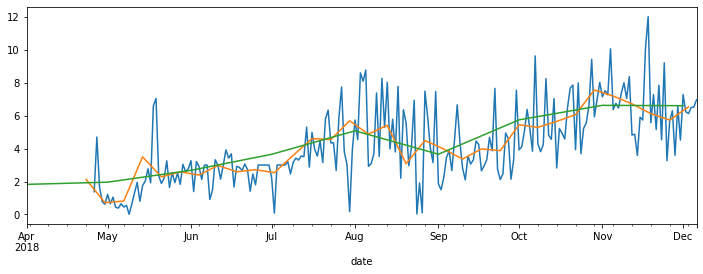

In [59]:
# distance 
df.distance.resample("D").mean().plot(figsize=(12,4))
df.distance.resample("W").mean().plot(figsize=(12,4))
df.distance.resample("M").mean().plot(figsize=(12,4))

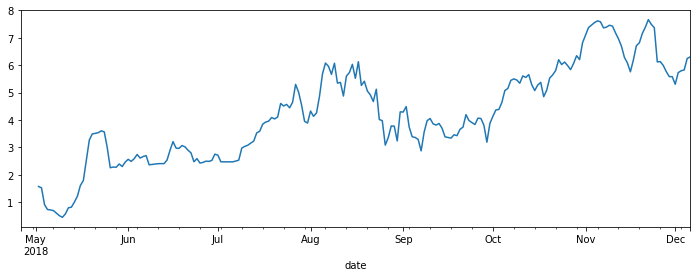

In [60]:
# one week/7 days
df.distance.rolling(7).mean().plot(figsize=(12,4))

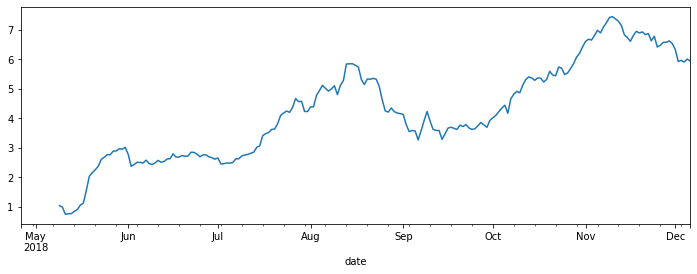

In [61]:
# every two weeks
df.distance.rolling(14).mean().plot(figsize=(12,4))

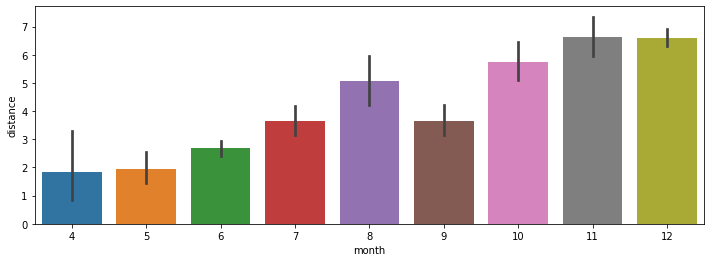

In [62]:
# follows trend of other vars, steps and calories burned, makes sense
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='distance')

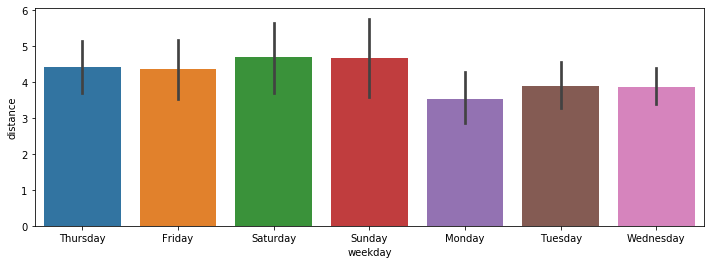

In [63]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='distance')

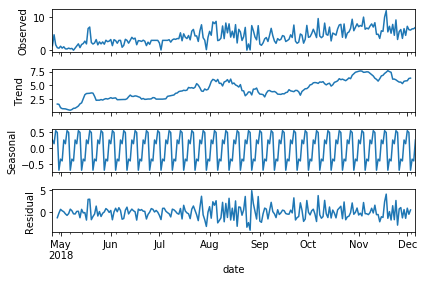

In [64]:
decomp = sm.tsa.seasonal_decompose(df['distance'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.show()

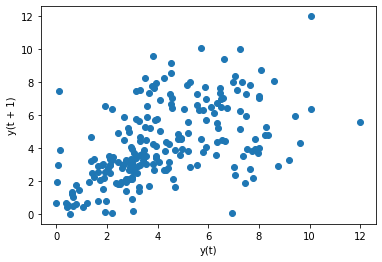

In [65]:
pd.plotting.lag_plot(df.distance.resample('D').mean(), lag=1)

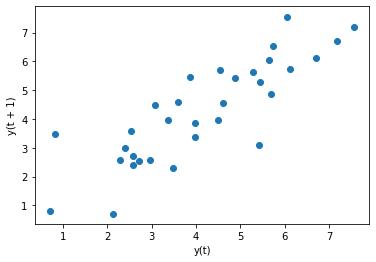

In [66]:
pd.plotting.lag_plot(df.distance.resample('W').mean(), lag=1)

### Distance per step

In [67]:
# distance per steps
df['distance_per_step'].resample("D").mean().plot(figsize=(12,4))
df['distance_per_step'].resample("W").mean().plot(figsize=(12,4))
df['distance_per_step'].resample("M").mean().plot(figsize=(12,4))

DataError: No numeric types to aggregate

In [ ]:
# gaps in the data around July, missing data for a few days
# large spike in distance per step around the end of the data
# dip around end of august, seen this before
df['distance_per_step'].resample("D").mean().plot(figsize=(12,4))

In [ ]:
df['distance_per_step'].resample("W").mean().plot(figsize=(12,4))

In [ ]:
# steady in most parts, then large differences
df['distance_per_step'].resample("D").mean().diff().plot(figsize=(12,4))

In [ ]:
# look at error bars, but cant get much from them
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='distance_per_step')

In [ ]:
# look at error bars, but cant get much from them
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='distance_per_step')

### Floors

In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='floors')

In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='floors')

In [ ]:
#Task: fill zeros ffill or bfill?
df.head()
# what do we want to predict? 
# predict steps

In [ ]:
df.activity_calories.value_counts()

### Total minutes logged

In [ ]:
df.total_minutes_logged.sort_values().head(15)

In [ ]:
weekday_totals = df.groupby(df.index.weekday).sum()

In [ ]:
weekday_totals.plot()

In [ ]:
df = df.resample('D').mean()

### Minutes Sedentary

In [ ]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Day', fontsize=16)

In [ ]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lighltly Active Minutes by Day', fontsize=16)

In [ ]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Day', fontsize=16)

In [ ]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Day', fontsize=16)

**Takeaway:** Thanksgiving was on Thurs Nov 22nd and it was user's 7th most active day and 5th most very active day

In [ ]:
df = df.resample('D').mean()

fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Day', fontsize=16)

**Takeaways:**
    - August 26th, user only wore fitbit for 41 mins
    - Wore fitbit all day a few times in July but never again after that

In [ ]:
df = df.resample('W').mean()

In [ ]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Week', fontsize=16)

In [ ]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lighltly Active Minutes by Week', fontsize=16)

In [ ]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Week', fontsize=16)

In [ ]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Week', fontsize=16)

In [ ]:
df = df.resample('W').mean()
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Week', fontsize=16)

**Takeaway:** April - July active levels have high variance including a very inactive first week of July. August through Dec is more constant. 

In [ ]:
df = df.resample('M').mean()

In [ ]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_1.set_title('Average Sedentary Minutes by Month', fontsize=16)

In [ ]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Lightly Active Minutes by Month', fontsize=16)

In [ ]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Fairly Active Minutes by Month', fontsize=16)

In [ ]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Very Active Minutes by Month', fontsize=16)

In [ ]:
df = df.resample('M').mean()
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
fig_4.set_title('Average Minutes per Activity Level by Month', fontsize=16)

**Takeaway:** Sedentary levels go down over time. Fitbit user becomes more consistently active as time goes on. 

In [ ]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_1 = daily_averages['minutes_very_active'].plot(figsize= (12,4))
fig_1.set_title('Average Very Active Minutes by Day of Week', fontsize=16)

In [ ]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_2 = daily_averages['minutes_fairly_active'].plot(figsize= (12,4))
fig_2.set_title('Average Fairly Active Minutes by Day of Week', fontsize=16)

In [ ]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_3 = daily_averages['minutes_lightly_active'].plot(figsize= (12,4))
fig_3.set_title('Average Lightly Active Minutes by Day of Week', fontsize=16)

In [ ]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_4 = daily_averages['minutes_sedentary'].plot(figsize= (12,4))
fig_4.set_title('Average Sedentary Minutes by Day of Week', fontsize=16)

**Takeaway:** Fitbit user is most active on Fridays and Wednesday. They do next to nothing on Tuesday and are also very inactive on Saturdays

## Modeling

In [ ]:
df = acquire.acquire_data()
df = prepare.prepare_data(df)
df.head(3)

In [ ]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [ ]:
train, test = split_store_data(df, train_prop=.70)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

In [ ]:
target_vars=['steps']
df = df.resample('D')[target_vars].sum()

In [ ]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

In [ ]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [ ]:
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [ ]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

In [ ]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [ ]:
yhat = pd.DataFrame(test[target_vars])
yhat.head(3)

## Model 1: Last Observed

In [ ]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

In [ ]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

## Model 2: Simple Average

In [ ]:
for var in target_vars:
    yhat[var] = train[var].mean()

In [ ]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

## Model 3: Moving Average

In [ ]:
periods = 10
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

In [ ]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

## Model 4: Holt's Linear Trend

In [ ]:
for var in target_vars:
    model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)

In [ ]:
# to do:
# organize notebook
# data dictionary
# combine exploration
# label graphs
# read me 
# slides

# get model.py funcions to work and remove functions from notebook
# loop through moving average model to find the best one
# impute days he didn't wear fitbit